# About_2 generation — sEMG time vs. PSD (raw vs. filtered)

**File:** `about_semg_figure.ipynb`  
**Purpose:** Generate a 2×2 figure for documentation and the JOSS paper:  
1. Raw sEMG (time)
2. Raw PSD (Welch)
3. Filtered sEMG + rectified-RMS envelope
4. Filtered PSD (Welch)

**Inputs:** None (synthetic by default)  
**Outputs:** `about_2.png`

**Author:** Steven R. Livingstone  
**Copyright:** 2025  
**License:** GPL-3.0-or-later
**Version:** 1.2 · 2025-11-04

**Changelog**  
- v1.0 (2025-10-30) Initial figure generator  
- v1.1 (2025-11-01) Panel letters; tighter layout  
- v1.2 (2025-11-04) Standardized header; doc aligned; notebook variant

**Usage**  
Run all cells. To reproduce with real data, replace `raw` with your 1-D array and set `fs`. Keep the same filtering and PSD steps; adjust `passband`, `Q`, and `rms_win_ms`.

**Reproducibility**  
RNG seed is fixed. Plot line lengths in any exported script are kept ≤79 chars to avoid wrapping issues in PDFs.

**Citation**  
If you use this figure, cite the EMGFlow JOSS paper and this repository.

### 0. Imports and paramters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import iirnotch, filtfilt, butter, sosfiltfilt, welch

# Initialise parameters
filename_output = 'about_2.png'
rng = np.random.default_rng(7)
fs = 2000                    # Hz sampling rate
dur = 3.0                    # seconds
mains_f0 = 60.0              # 50.0 in some regions
passband = (20.0, 450.0)     # Hz (typical facial/limb sEMG)
rms_win_ms = 50              # envelope window

### 1. Synthetic sEMG segment

In [2]:
t = np.arange(0, dur, 1/fs)

def muap_kernel(L=0.015, fs=fs):
    n = int(L * fs)
    n = max(n, 8)
    x = np.linspace(-1.5, 1.5, n)
    g = np.exp(-x**2 / 0.1) * np.sin(2*np.pi*90*x)
    g /= np.max(np.abs(g))
    return g

k = muap_kernel()
sig = np.zeros_like(t)

for rate, amp in [(12, 0.8), (18, 0.6), (25, 0.5)]:
    spikes = rng.random(t.size) < (rate/fs)
    sig += np.convolve(spikes.astype(float), k, mode="same") * amp

drift = 0.15 * np.sin(2*np.pi*0.2*t)
white = 0.15 * rng.standard_normal(t.size)
pink = np.convolve(white, np.ones(25)/25, mode="same") * 0.5
hum = 0.10 * np.sin(2*np.pi*mains_f0*t)
hum += 0.05 * np.sin(2*np.pi*2*mains_f0*t)
raw = sig + white + 0.3*pink + drift + hum

### 2. Filtering: notch + bandpass

In [3]:
Q = 30.0
b_notch, a_notch = iirnotch(w0=mains_f0, Q=Q, fs=fs)
raw_notched = filtfilt(b_notch, a_notch, raw)

sos = butter(5, [passband[0], passband[1]], btype="band",
             fs=fs, output="sos")
filt = sosfiltfilt(sos, raw_notched)

win = int((rms_win_ms/1000.0) * fs)
win = max(win, 8) | 1
rect = np.abs(filt)
kernel = np.ones(win) / win
env = np.sqrt(np.convolve(rect**2, kernel, mode="same"))

### 3. PSDs (Welch)

In [4]:
nper = int(0.5 * fs)
nover = int(0.5 * nper)
f_raw, Pxx_raw = welch(raw, fs=fs, nperseg=nper, noverlap=nover,
                       window="hann", scaling="density")
f_flt, Pxx_flt = welch(filt, fs=fs, nperseg=nper, noverlap=nover,
                       window="hann", scaling="density")

### 4. Generate plot and save

Saved: about_2.png


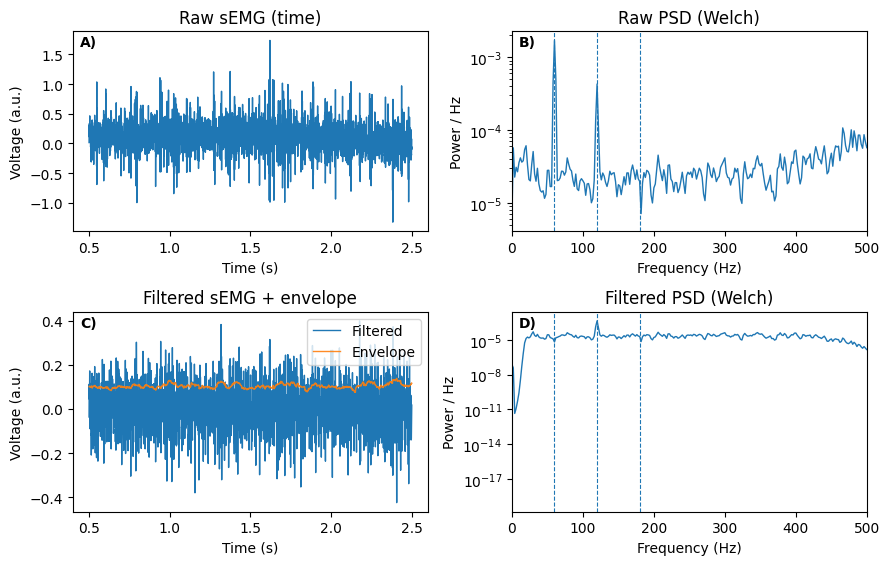

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(9, 6))
(axA, axB), (axC, axD) = axes

def label(ax, txt):
    ax.text(0.02, 0.98, txt, transform=ax.transAxes, va="top",
            ha="left", fontweight="bold")

# A: raw time
t0, t1 = 0.5, 2.5
mask = (t >= t0) & (t <= t1)
axA.plot(t[mask], raw[mask], linewidth=1.0)
axA.set_title("Raw sEMG (time)")
axA.set_xlabel("Time (s)")
axA.set_ylabel("Voltage (a.u.)")
label(axA, "A)")

# B: raw PSD
axB.semilogy(f_raw, Pxx_raw, linewidth=1.0)
for kline in (1, 2, 3):
    axB.axvline(kline*mains_f0, linestyle="--", linewidth=0.8)
axB.set_xlim(0, 500)
axB.set_title("Raw PSD (Welch)")
axB.set_xlabel("Frequency (Hz)")
axB.set_ylabel("Power / Hz")
label(axB, "B)")

# C: filtered time + envelope
axC.plot(t[mask], filt[mask], linewidth=1.0, label="Filtered")
axC.plot(t[mask], env[mask], linewidth=1.0, alpha=0.9, label="Envelope")
axC.set_title("Filtered sEMG + envelope")
axC.set_xlabel("Time (s)")
axC.set_ylabel("Voltage (a.u.)")
axC.legend(loc="upper right", frameon=True)
label(axC, "C)")

# D: filtered PSD
axD.semilogy(f_flt, Pxx_flt, linewidth=1.0)
for kline in (1, 2, 3):
    axD.axvline(kline*mains_f0, linestyle="--", linewidth=0.8)
axD.set_xlim(0, 500)
axD.set_title("Filtered PSD (Welch)")
axD.set_xlabel("Frequency (Hz)")
axD.set_ylabel("Power / Hz")
label(axD, "D)")

fig.tight_layout(rect=[0, 0.0, 1, 0.96])
fig.savefig(filename_output, dpi=200)
print(f"Saved: {filename_output}")